In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
from models.model_fpgan import FPGANSynthesizer

import ctgan
from sklearn.model_selection import train_test_split
from utils.privacy import normalized_avg_dist
from utils.fidelity import get_predictions, eval_fidelity

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [29]:
# tem 3 classes, n usar para ja
data = pd.read_csv("D:/Datasets/breast/data.csv")
data = data.drop(columns=['Unnamed: 32'])
data = data.drop(columns=['id'])
data.loc[data["diagnosis"] == 'M' , "diagnosis"] = 0
data.loc[data["diagnosis"] == 'B' , "diagnosis"] = 1
data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [30]:
#normalized_data=(data-data.mean())/data.std()
data=(data-data.min())/(data.max()-data.min())
data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0.0,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.70314,0.731113,0.686364,...,0.620776,0.141525,0.66831,0.450698,0.601136,0.619292,0.56861,0.912027,0.598462,0.418864
1,0.0,0.643144,0.272574,0.615783,0.501591,0.28988,0.181768,0.203608,0.348757,0.379798,...,0.606901,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.23359,0.222878
2,0.0,0.601496,0.39026,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,...,0.556386,0.360075,0.508442,0.374508,0.48359,0.385375,0.359744,0.835052,0.403706,0.213433
3,0.0,0.21009,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,...,0.24831,0.385928,0.241347,0.094008,0.915472,0.814012,0.548642,0.88488,1.0,0.773711
4,0.0,0.629893,0.156578,0.630986,0.48929,0.430351,0.347893,0.463918,0.51839,0.378283,...,0.519744,0.123934,0.506948,0.341575,0.437364,0.172415,0.319489,0.558419,0.1575,0.142595


In [31]:
target = 'diagnosis'

In [32]:
X = data.drop(columns=[target])
y = data[target]
y=y.astype('int')

In [33]:
model_ctgan = FPGANSynthesizer(epochs=25, verbose=True)
losses, tranformed_privacies = model_ctgan.fit(data)

Epoch 1, Loss G: -0.0805,Loss D:  0.0617
Epoch 2, Loss G: -0.0635,Loss D: -0.0226
Epoch 3, Loss G: -0.0716,Loss D: -0.0152
Epoch 4, Loss G: -0.0818,Loss D: -0.0888
Epoch 5, Loss G: -0.0910,Loss D: -0.1180
Epoch 6, Loss G: -0.1065,Loss D: -0.1898
Epoch 7, Loss G: -0.0779,Loss D: -0.2141
Epoch 8, Loss G: -0.1207,Loss D: -0.3352
Epoch 9, Loss G: -0.1719,Loss D: -0.3687
Epoch 10, Loss G: -0.2218,Loss D: -0.5373
Epoch 11, Loss G: -0.2932,Loss D: -0.5548
Epoch 12, Loss G: -0.4133,Loss D: -0.6304
Epoch 13, Loss G: -0.4754,Loss D: -0.6088
Epoch 14, Loss G: -0.6609,Loss D: -0.6521
Epoch 15, Loss G: -0.7634,Loss D: -0.6769
Epoch 16, Loss G: -0.8788,Loss D: -0.5664
Epoch 17, Loss G: -1.0980,Loss D: -0.5854
Epoch 18, Loss G: -1.3273,Loss D: -0.7161
Epoch 19, Loss G: -1.4249,Loss D: -0.6838
Epoch 20, Loss G: -1.7238,Loss D: -0.5416
Epoch 21, Loss G: -1.8497,Loss D: -0.4162
Epoch 22, Loss G: -2.0121,Loss D: -0.2371
Epoch 23, Loss G: -2.1349,Loss D: -0.2476
Epoch 24, Loss G: -2.1840,Loss D: -0.2175
E

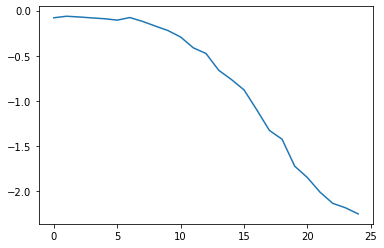

In [34]:
plt.plot(losses)
plt.show()

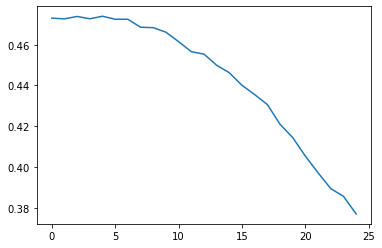

In [35]:
plt.plot(tranformed_privacies)
plt.show()

In [36]:
samples = model_ctgan.sample(len(data))  # Synthetic copy
samples.dropna(how='any', inplace=True)

X_syn = samples.drop(columns=[target])
y_syn = samples[target]
y_syn = y_syn.round(0)
y_syn = y_syn.astype(int)

## Privacy

In [37]:
samples = samples.apply(pd.to_numeric) # convert all columns of DataFrame
data = data.apply(pd.to_numeric) # convert all columns of DataFrame

In [38]:
normalized_avg_distance = normalized_avg_dist(samples, data)
print(normalized_avg_distance)

[0.16993803]


In [39]:
samples.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1.077623,0.047482,0.334705,0.322758,0.180394,0.172998,0.438001,0.130144,0.772711,0.096786,...,0.426789,0.380072,0.190576,0.197260,0.538076,0.544284,-0.011881,0.532916,-0.038831,-0.042070
1,0.912329,0.328808,0.426649,0.114398,0.140829,0.240661,0.172181,-0.005845,0.249851,0.276097,...,-0.001110,0.338820,0.174068,0.245525,0.188471,0.262321,0.054889,0.464928,0.219492,0.120692
2,-0.023502,-0.034205,0.455882,0.115519,0.133903,0.268314,-0.050942,0.133172,0.267797,0.354735,...,0.293531,0.683548,0.640933,0.164364,0.271471,0.229919,-0.044137,0.659755,0.270292,0.068799
3,0.998401,0.098249,0.543776,0.123656,0.177946,0.354306,0.516952,0.229136,0.186731,0.284315,...,0.753529,0.769822,0.267045,0.152921,0.413877,0.158388,-0.058357,1.082101,0.160721,0.059534
4,0.930029,0.226681,0.636304,0.279176,0.539101,0.090575,-0.025899,0.022388,0.168558,0.237177,...,0.857348,0.233095,0.608313,0.150071,0.328478,0.158169,0.035130,0.830754,0.162205,0.046342


## Fidelity

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_syn, y_syn, test_size=0.3, random_state=42)

rr_pred = []
fr_pred = []
ff_pred = []
rf_pred = []

rr_pred = get_predictions(X_train, y_train, X_test, y_test)
fr_pred = get_predictions(X_syn_train, y_syn_train, X_test, y_test)

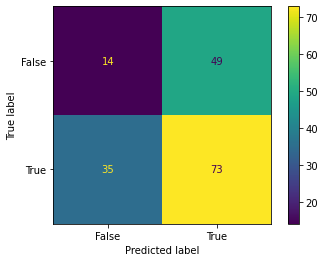

In [41]:
from sklearn import metrics
def print_confusion_matrix(rr_pred, fr_pred):
    confusion_matrix = metrics.confusion_matrix(rr_pred, fr_pred)

    cm_display1 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display1.plot()
    plt.show()
    
print_confusion_matrix(rr_pred, fr_pred)

In [42]:
percentage, same_pred, dif_pred = eval_fidelity(rr_pred, fr_pred)

In [43]:
print(same_pred, dif_pred)

87 84


## Final plot

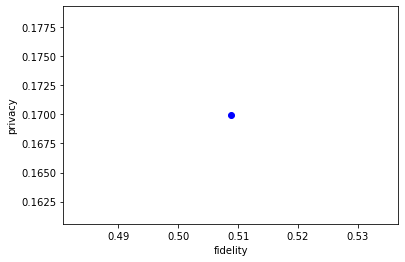

In [44]:
plt.scatter(percentage, normalized_avg_distance, c ="blue")
plt.xlabel("fidelity")
plt.ylabel("privacy")
plt.show()